In [1]:
import torch
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("Current Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


Is CUDA available: True
CUDA Device Count: 1
Current Device Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [ ]:
print(f"Allocated before: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB, Cached before: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")

print(f"Allocated after: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB, Cached after: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")

In [1]:
import torch, time, gc

# Timing utilities
start_time = None

def start_timer():
    global start_time
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.synchronize()
    start_time = time.time()

def end_timer_and_print(local_msg):
    torch.cuda.synchronize()
    end_time = time.time()
    print("\n" + local_msg)
    print("Total execution time = {:.3f} sec".format(end_time - start_time))
    print("Max memory used by tensors = {} bytes".format(torch.cuda.max_memory_allocated()))

In [1]:
from utils.dataset import DatasetFormatter
from torch_geometric.loader import DataLoader
import torch.multiprocessing as mp
from utils.noise import get_velocity_noise
from simulator import Simulator
import torch
from utils.utils import NodeType
# from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR
torch.cuda.empty_cache()

#training parameters
noise_std=0
learning_rate = 3e-4
max_epoch = 1000
batch_size = 1
open_tran_num = 5
accumulations_step = 3
patience = 3
factor_schedule = 0.1

#model parameters
node_attr_size = 3      # ini samain dengan node attr size yang udh ada one hot encoding di simulator.py
edge_attr_size = 1      # Matches dummy edge features
latent_dim_size = 24    # Latent space dimension
message_passing_num = 3 # Number of message passing steps
print_batch = 10
save_batch = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model = Simulator(latent_dim_size=latent_dim_size, 
                  message_passing_num=message_passing_num, 
                  node_input_size=node_attr_size, 
                  edge_input_size=edge_attr_size, 
                  device=device)
model.load_checkpoint('model_collection/best_24.pth')
optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor_schedule, patience=patience)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=70, epochs=max_epoch)

loss_fn = torch.nn.MSELoss().cpu()
scaler = torch.cuda.amp.GradScaler()

# start_timer() 
if __name__ == '__main__':
    # mp.set_start_method('spawn')
    for i in range(max_epoch):
        dataset = DatasetFormatter(max_epochs=max_epoch, open_tra_num=open_tran_num, dataset_dir="dataset_split")
        train_loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
        
        for batch_index, graph in enumerate(train_loader):
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                graph = graph.cuda()

                node_type = graph.x[:, 0]
                velocity_sequence_noise = get_velocity_noise(graph, noise_std=noise_std)
                
                predicted_acc, target_acc = model(graph, velocity_sequence_noise) # only taking the velocity attributes
            
                mask = torch.logical_or(node_type==NodeType.NORMAL, node_type==NodeType.FARFIELD) # only taking the fluid nodes, not the solid/inlet/farfield
                                                                                                                    
                # errors = ((predicted_acc - target_acc)**2) # for x and y vel without solid body
                # loss = torch.mean(errors[mask])
                loss = loss_fn(predicted_acc[mask], target_acc[mask])

            # grad accumu
            # if batch_index%accumulations_step == 0:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            # loss.backward()
            optimizer.zero_grad() #lumayan turun 500 Mb
            # optimizer.step()
            
            # set_to_none=True

            
            if batch_index % print_batch == 0:
                print('epoch %d :batch %d [loss %.2e]'%(i, batch_index, loss.item()))

            if batch_index % save_batch == 0 and batch_index != 0:
                model.save_checkpoint()

            # end_timer_and_print('Default:')
            # break
        # break

c:\Users\Yuno\anaconda3\envs\gmn-venv\lib\site-packages\torch_cluster\nearest.py:3: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.1)
  import scipy.cluster


Simulator model initialized
Simulator model loaded checkpoint model_collection/best_24.pth
Dataset dataset_split\train.h5 Initilized
epoch 0 :batch 0 [loss 8.94e-01]
Simulator model saved at checkpoint/simulator.pth
epoch 0 :batch 10 [loss 8.91e-01]
epoch 0 :batch 20 [loss 8.81e-01]
epoch 0 :batch 30 [loss 8.82e-01]
epoch 0 :batch 40 [loss 8.85e-01]
epoch 0 :batch 50 [loss 8.67e-01]
epoch 0 :batch 60 [loss 8.96e-01]
Epoch Finished
Dataset dataset_split\train.h5 Initilized
epoch 1 :batch 0 [loss 9.10e-01]
Simulator model saved at checkpoint/simulator.pth
epoch 1 :batch 10 [loss 8.89e-01]
epoch 1 :batch 20 [loss 8.94e-01]
epoch 1 :batch 30 [loss 8.98e-01]
epoch 1 :batch 40 [loss 8.82e-01]
epoch 1 :batch 50 [loss 8.95e-01]
epoch 1 :batch 60 [loss 8.68e-01]
Epoch Finished
Dataset dataset_split\train.h5 Initilized
epoch 2 :batch 0 [loss 9.07e-01]
Simulator model saved at checkpoint/simulator.pth
epoch 2 :batch 10 [loss 8.83e-01]
epoch 2 :batch 20 [loss 8.89e-01]
epoch 2 :batch 30 [loss 8.97

KeyboardInterrupt: 

In [1]:
from utils.dataset import DatasetFormatter
from torch_geometric.loader import DataLoader
import torch.multiprocessing as mp
from utils.noise import get_velocity_noise
from simulator import Simulator
import torch
from utils.utils import NodeType
# from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR
torch.cuda.empty_cache()

#training parameters
noise_std=0
learning_rate = 3e-4
max_epoch = 1000
batch_size = 1
open_tran_num = 5
accumulations_step = 3
patience = 3
factor_schedule = 0.1

#model parameters
node_attr_size = 3      # ini samain dengan node attr size yang udh ada one hot encoding di simulator.py
edge_attr_size = 1      # Matches dummy edge features
latent_dim_size = 64    # Latent space dimension
message_passing_num = 10 # Number of message passing steps
print_batch = 10
save_batch = 300

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model = Simulator(latent_dim_size=latent_dim_size, 
                  message_passing_num=message_passing_num, 
                  node_input_size=node_attr_size, 
                  edge_input_size=edge_attr_size, 
                  device=device)
# model.load_checkpoint('model_collection/best_24.pth')
optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor_schedule, patience=patience)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=70, epochs=max_epoch)

loss_fn = torch.nn.MSELoss().cpu()
scaler = torch.cuda.amp.GradScaler()

if __name__ == '__main__':
    # mp.set_start_method('spawn')
    for i in range(max_epoch):
        dataset = DatasetFormatter(max_epochs=max_epoch, open_tra_num=open_tran_num, dataset_dir="dataset_split")
        train_loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
        
        for batch_index, graph in enumerate(train_loader):
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                graph = graph.cuda()

                node_type = graph.x[:, 0]
                velocity_sequence_noise = get_velocity_noise(graph, noise_std=noise_std)
                
                predicted_acc, target_acc = model(graph, velocity_sequence_noise) # only taking the velocity attributes
            
                mask = torch.logical_or(node_type==NodeType.NORMAL, node_type==NodeType.FARFIELD) # only taking the fluid nodes, not the solid/inlet/farfield
                                                    
                loss = loss_fn(predicted_acc[mask], target_acc[mask])

            # grad accumu
            # if batch_index%accumulations_step == 0:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True) #lumayan turun 500 Mb

            
            if batch_index % print_batch == 0:
                print('epoch %d :batch %d [loss %.2e]'%(i, batch_index, loss.item()))

            if batch_index % save_batch == 0 and batch_index != 0:
                model.save_checkpoint()

c:\Users\Yuno\anaconda3\envs\gmn-venv\lib\site-packages\torch_cluster\nearest.py:3: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.1)
  import scipy.cluster


Simulator model initialized
Dataset dataset_split\train.h5 Initilized
epoch 0 :batch 0 [loss 1.01e+00]
epoch 0 :batch 10 [loss 9.94e-01]
epoch 0 :batch 20 [loss 9.93e-01]
epoch 0 :batch 30 [loss 1.01e+00]
epoch 0 :batch 40 [loss 9.93e-01]
epoch 0 :batch 50 [loss 9.90e-01]
epoch 0 :batch 60 [loss 1.00e+00]
Epoch Finished
Dataset dataset_split\train.h5 Initilized
epoch 1 :batch 0 [loss 1.00e+00]
epoch 1 :batch 10 [loss 9.93e-01]
epoch 1 :batch 20 [loss 9.88e-01]
epoch 1 :batch 30 [loss 9.90e-01]
epoch 1 :batch 40 [loss 1.00e+00]
epoch 1 :batch 50 [loss 9.80e-01]
epoch 1 :batch 60 [loss 9.97e-01]
Epoch Finished
Dataset dataset_split\train.h5 Initilized
epoch 2 :batch 0 [loss 9.86e-01]
epoch 2 :batch 10 [loss 9.86e-01]
epoch 2 :batch 20 [loss 9.76e-01]
epoch 2 :batch 30 [loss 9.75e-01]
epoch 2 :batch 40 [loss 9.83e-01]
epoch 2 :batch 50 [loss 9.76e-01]
epoch 2 :batch 60 [loss 9.70e-01]
Epoch Finished
Dataset dataset_split\train.h5 Initilized
epoch 3 :batch 0 [loss 9.76e-01]
epoch 3 :batch 

KeyboardInterrupt: 

In [2]:
model.save_checkpoint()

Simulator model saved at checkpoint/simulator.pth


# TODO: 

- cobain scheduler
- buat rollout

In [ ]:
from simulator import Simulator
import torch
from utils.dataset import DatasetFormatter, DatasetFormat
from torch_geometric.loader.dataloader import DataLoader
from utils.noise import get_velocity_noise

torch.cuda.empty_cache()
device = "cuda:0"
dataset = DatasetFormatter(max_epochs=10, dataset_dir="dataset_split", split='val', device=device)
train_loader = DataLoader(dataset=dataset, batch_size=1, num_workers=0)

test = dataset.__iter__()
gr = test.__next__()

c:\Users\Yuno\anaconda3\envs\gmn-venv\lib\site-packages\torch_cluster\nearest.py:3: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.1)
  import scipy.cluster


Dataset dataset_split\val.h5 Initilized


In [5]:
gr

Data(x=[322404, 3], edge_index=[2, 2894416], y=[322404, 2], pos=[322404, 2])

In [1]:
from simulator import Simulator
import torch
from utils.dataset import DatasetFormatter
from torch_geometric.loader.dataloader import DataLoader
import numpy as np

device = "cuda:0"
dataset = DatasetFormatter(max_epochs=10, 
                           dataset_dir="dataset_split", 
                           split= 'train',
                           open_tra_num=5, 
                           device=device)

train_loader = DataLoader(dataset=dataset, batch_size=1, num_workers=0)

noise_std=0

# Define the model parameters
node_attr_size = 3      # ini samain dengan node attr size yang udh ada one hot encoding di simulator.py
edge_attr_size = 1      # Matches dummy edge features
latent_dim_size = 24    # Latent space dimension
message_passing_num = 3 # Number of message passing steps
print_batch = 1
save_batch = 20

model = Simulator(latent_dim_size=latent_dim_size, 
                  message_passing_num=message_passing_num, 
                  node_input_size=node_attr_size, 
                  edge_input_size=edge_attr_size, 
                  device=device, 
                  training=True)

model.load_checkpoint('model_collection/best_24.pth')

predicts = []
GT = []
errors =[]
for batch_index, graph in enumerate(train_loader):
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        #x vel, y vel, 4 label
        graph.cuda()

        print(f"Predict batch: {batch_index}")
        predict, ground_truth = model(graph)
        
        node_type = graph.x[:, 0].detach().cpu()
        mask = torch.logical_or(node_type == 0, node_type == 1)
    predicts.append(predict.detach().cpu().numpy())
    GT.append(ground_truth.detach().cpu().numpy())
    torch.cuda.empty_cache()
    error = np.sqrt((GT[0][mask] - predicts[0][mask])**2)
    errors.append(error)
    break
    


c:\Users\Yuno\anaconda3\envs\gmn-venv\lib\site-packages\torch_cluster\nearest.py:3: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.1)
  import scipy.cluster


Dataset dataset_split\train.h5 Initilized
Simulator model initialized
Simulator model loaded checkpoint model_collection/best_24.pth
Predict batch: 0


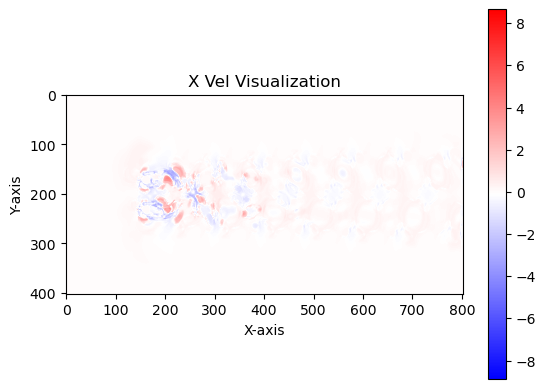

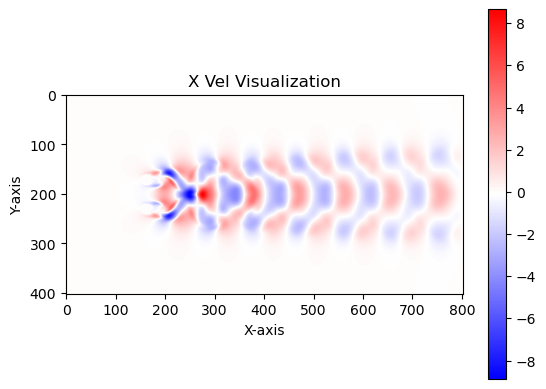

In [3]:
import matplotlib.pyplot as plt
predict_res = predicts[0][:, 0].reshape(402, 802) # x and y velocity
GT_res = GT[0][:, 0].reshape(402, 802) # x and y velocity

vmin = min(predict_res.min(), GT_res.min())
vmax = max(predict_res.max(), GT_res.max())

plt.imshow(predict_res, cmap = 'bwr', vmin=vmin, vmax=vmax)
plt.colorbar()  # Add the color scale
plt.title("X Vel Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

plt.imshow(GT_res, cmap = 'bwr', vmin=vmin, vmax=vmax)
plt.colorbar()  # Add the color scale
plt.title("X Vel Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

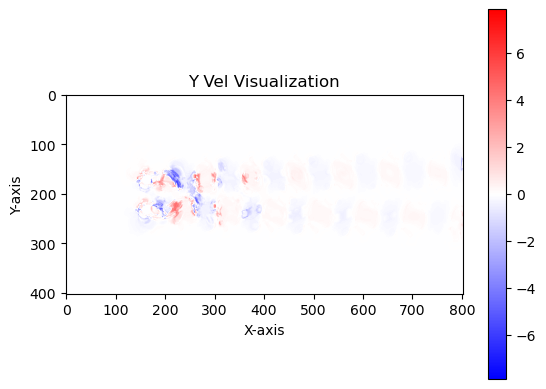

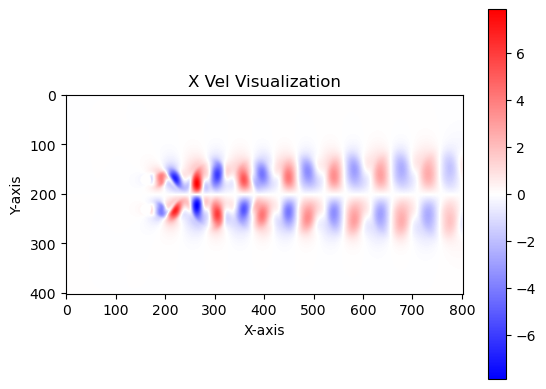

In [4]:
import matplotlib.pyplot as plt
predict_res = predicts[0][:, 1].reshape(402, 802) # x and y velocity
GT_res = GT[0][:, 1].reshape(402, 802) # x and y velocity

vmin = min(predict_res.min(), GT_res.min())
vmax = max(predict_res.max(), GT_res.max())

plt.imshow(predict_res, cmap = 'bwr', vmin=vmin, vmax=vmax)
plt.colorbar()  # Add the color scale
plt.title("Y Vel Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

plt.imshow(GT_res, cmap = 'bwr', vmin=vmin, vmax=vmax)
plt.colorbar()  # Add the color scale
plt.title("X Vel Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

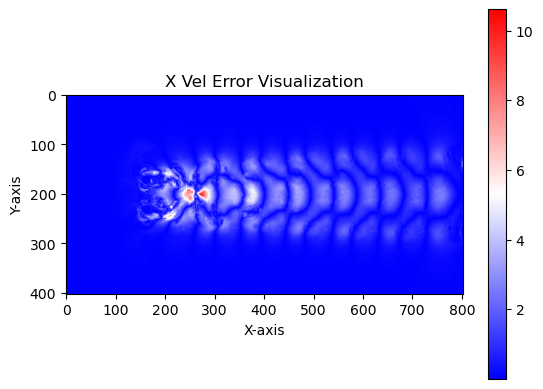

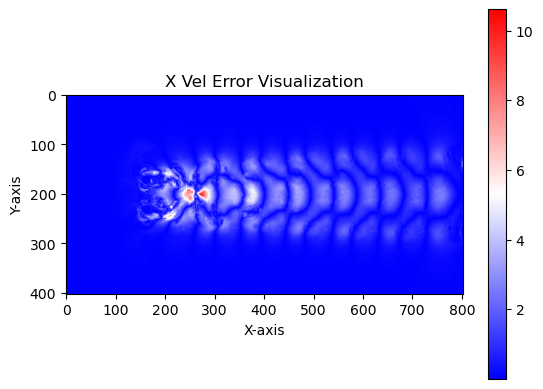

In [7]:
import matplotlib.pyplot as plt

# errors = np.sqrt((GT[0] - predicts[0])**2)
x_errors_res = errors[0][:, 0].reshape(402, 802) # x and y velocity
y_errors_res = errors[0][:, 0].reshape(402, 802) # x and y velocity

xmin = x_errors_res.min()
xmax = x_errors_res.max()

plt.imshow(x_errors_res, cmap = 'bwr', vmin=xmin, vmax=xmax)
plt.colorbar()  # Add the color scale
plt.title("X Vel Error Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

ymin = y_errors_res.min()
ymax = y_errors_res.max()

plt.imshow(x_errors_res, cmap = 'bwr', vmin=ymin, vmax=ymax)
plt.imshow(y_errors_res, cmap = 'bwr')
plt.colorbar()  # Add the color scale
plt.title("X Vel Error Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()